# Tarea
KADIR ORTEGA - ELIANNA GOMEZ

## PUNTO 1
Considere la **`serie de tiempo`** asociada con los futuros de la criptomoneda Bitcoin desde que comenzó a comercializarse hasta la fecha del día de hoy. Utilice la API de Yahoo Finance para obtener esta serie de tiempo.

## PUNTO 2
Repita TODOS los pasos indicados en esta sección para encontrar modelos ARIMA para predecir el precio de Bitcoin con los siguientes horizontes: 7, 14, 21 y 28 días. Utilizar siempre predicciones usando rolling con ventana de predicción continua de un día. Cualquier cantidad de pasos extra para enriquecer su análisis predictivo serán aceptados siempre y cuando sean acordes con lo que indica la teoría de análisis de series de tiempo.



![Bitcoin](Bitcoin.png)


Website [Yfinace](https://finance.yahoo.com/quote/BTC-USD)




IMPORTAMOS LIBRERIAS:

In [47]:
#Importamos Librerias
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

import datetime as dt
import pandas as pd
import numpy as np
import time
import yfinance as yf
from yahoo_fin.stock_info import get_data
import pmdarima as pm
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_predict
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime, timedelta
from scipy.stats import shapiro
from statsmodels.stats.stattools import durbin_watson



DESCARGAMOS LOS DATOS HISTORICO UTILIZANDO LA BIBLIOTECA **`yahoo_fin`**

In [3]:
bitcoin = yf.Ticker("BTC-USD")
hist = bitcoin.history(period="max")
TotalDatahist = len(hist)
stock = 'BTC-USD'
resolution = '1d'
end_date = datetime.now()
start_date = end_date - timedelta(TotalDatahist)
def date_format(date_h):
    return date_h.strftime('%d/%m/%Y')

BTC_df = get_data(stock, start_date=start_date, end_date=end_date, interval=resolution, index_as_date=False)
BTC_df.head()


,date,open,high,low,close,adjclose,volume,ticker
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,BTC-USD
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,BTC-USD
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,BTC-USD
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,BTC-USD
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,BTC-USD


REALIZAMOS GRAFICO DE LA SERIE DE TIEMPO DEL BITCOIN

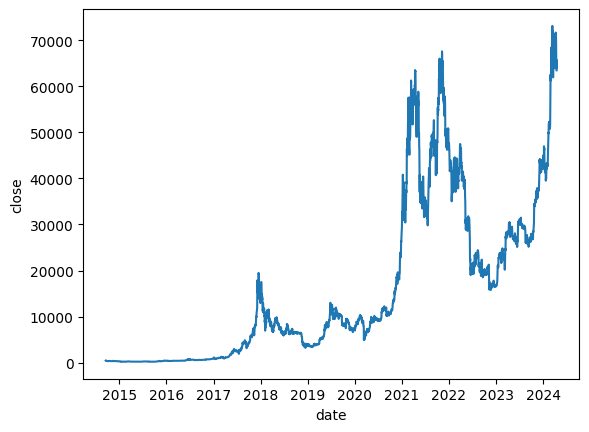

In [4]:
sns.lineplot(data=BTC_df, x=BTC_df.date, y=BTC_df.close);

GRAFICO DE VELA

In [5]:
bitcoin = yf.Ticker("BTC-USD")

hist = bitcoin.history(period="max")

fig = go.Figure(data=[go.Candlestick(x=hist.index,
                                     open=hist['Open'],
                                     high=hist['High'],
                                     low=hist['Low'],
                                     close=hist['Close'])])


fig.update_layout(title='Gráfica de Velas del Histórico de Bitcoin',
                  xaxis_title='Fecha',
                  yaxis_title='Precio en USD',
                  xaxis_rangeslider_visible=False)  


fig.show()


PRUEBA **`Dickey-Fuller`** - PRUEBA ESTADISTICA PARA VERIFICAR SI LA SERIE DE TIEMPO ES ESTACIONARIA O NO.


In [6]:
result = adfuller(BTC_df.close)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

test_result = adfuller(BTC_df.close)

adf_statistic = test_result[0]
p_value = test_result[1]
critical_values = test_result[4]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
for key, value in critical_values.items():
    print(f'Critical Value {key}: {value}')

if p_value < 0.05:
    print("La serie es estacionaria.")
else:
    print("La serie no es estacionaria.")

ADF Statistic: -0.804356
p-value: 0.817839
ADF Statistic: -0.8043557298768268
p-value: 0.8178392553499195
Critical Value 1%: -3.4322364645313335
Critical Value 5%: -2.862373532387402
Critical Value 10%: -2.567213704163575
La serie no es estacionaria.


Podemos observar en el resultado que obtuvismo que la serie es no estacionaria, debido a que el p-value es mayor que **5%**.

Dado que la serie del Bitcoin no es estacionaria procedemos al siguiente paso, que es diferenciar nuestra serie y realizamos graficos de autocorrelación.


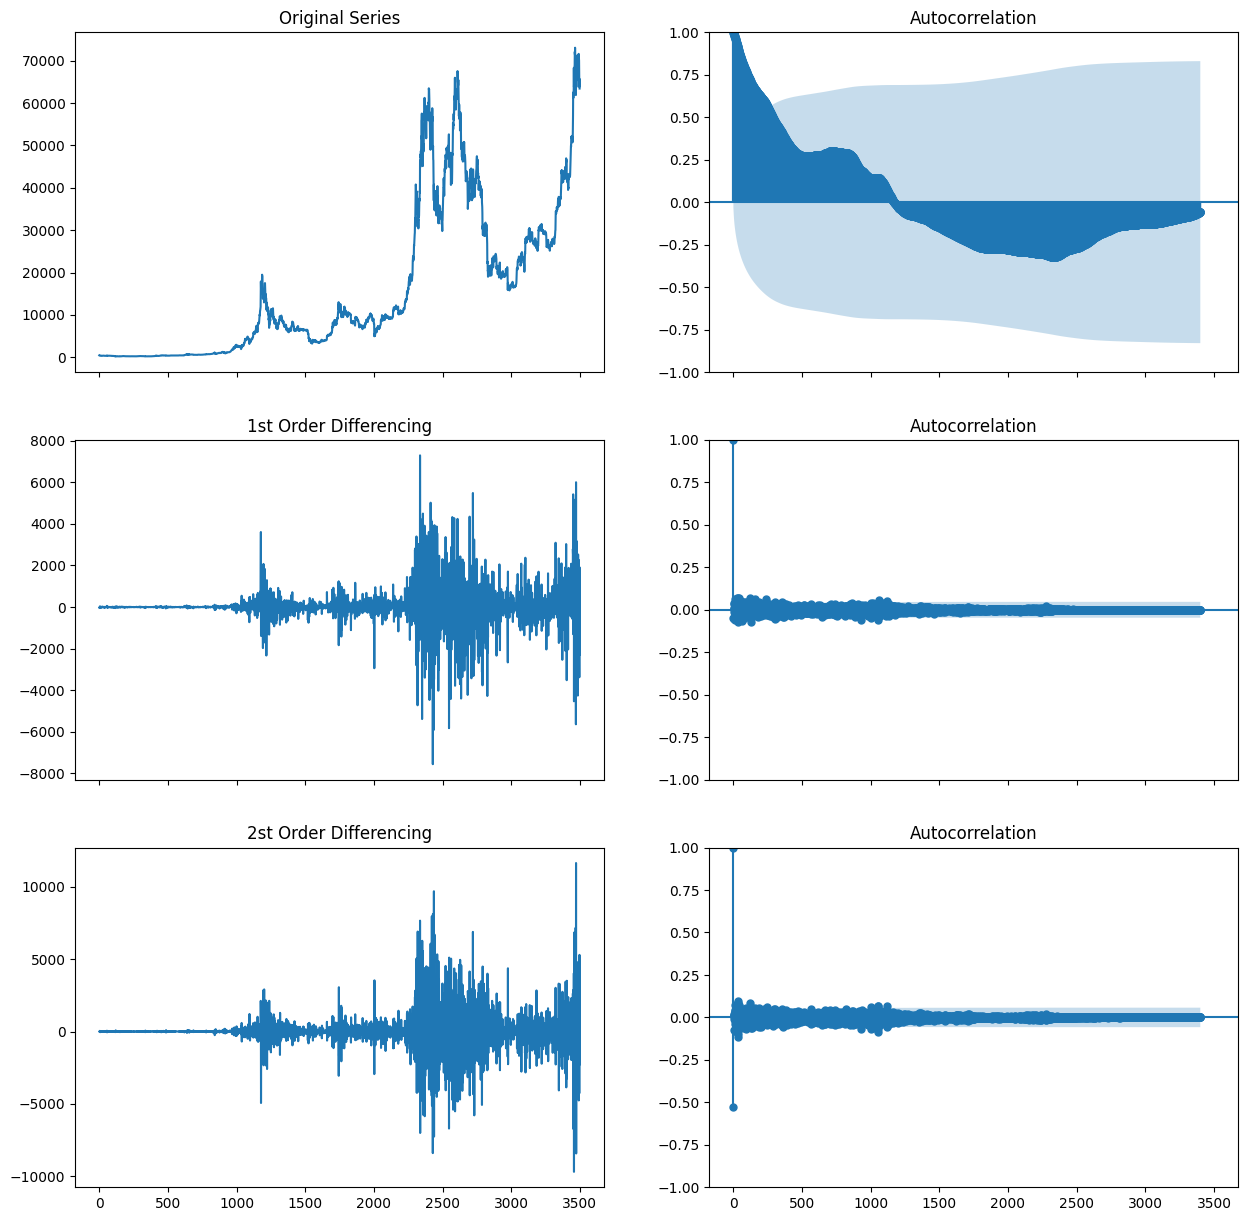

In [7]:
plt.rcParams.update({'figure.figsize': (15,15)})

fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(BTC_df.close); axes[0, 0].set_title('Original Series')
plot_acf(BTC_df.close, ax=axes[0, 1], lags = 3400);

axes[1, 0].plot(BTC_df.close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(BTC_df.close.diff().dropna(), ax=axes[1, 1], lags = 3400);

axes[2, 0].plot(BTC_df.close.diff().diff()); axes[2, 0].set_title('2st Order Differencing')
plot_acf(BTC_df.close.diff().diff().dropna(), ax=axes[2, 1], lags = 3400);

Los gráficos de autocorrelación indican que el lag 1 es el único que está correlacionado con el lag 0. Los siguientes lags no superan el umbral de significancia.

PREPARACION DE LOS DATOS DE ENTRENAMIENTO Y DATOS DE PRUEBA

In [8]:
n_BTC = len(BTC_df.close) 
n_test = 28 
train_size = n_BTC - n_test
train = BTC_df.close[:train_size]
dates_train = BTC_df.date[:train_size]
test = BTC_df.close[train_size:train_size + n_test]
dates_test = BTC_df.date[train_size:train_size + n_test]

print("train shape:", n_BTC)
print("train shape:", train.shape)
print("test shape:", test.shape)
dates_train

train shape: 3499
train shape: (3471,)
test shape: (28,)


0      2014-09-17
1      2014-09-18
2      2014-09-19
3      2014-09-20
4      2014-09-21
          ...    
3466   2024-03-14
3467   2024-03-15
3468   2024-03-16
3469   2024-03-17
3470   2024-03-18
Name: date, Length: 3471, dtype: datetime64[ns]

CALCULAMOS EL MEJOR AIC Y LOS VALORES P, D, Q

In [9]:
best_aic = np.inf
best_bic = np.inf

best_order = None
best_mdl = None

pq_rng = range(5)
d_rng  = range(3)

for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                
                tmp_mdl = ARIMA(train, order=(i,d,j)).fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 56303.79791 | order: (4, 1, 4)


Como podemos ver, el mejor orden de los valore P, D, Q elegidos son Arima(4,1,4) 

Implementación del Modelo

In [10]:
model = ARIMA(train, order=best_order)
model_arima = model.fit()
print(model_arima.summary())


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 3471
Model:                 ARIMA(4, 1, 4)   Log Likelihood              -28142.899
Date:                Mon, 15 Apr 2024   AIC                          56303.798
Time:                        18:25:55   BIC                          56359.165
Sample:                             0   HQIC                         56323.566
                               - 3471                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0014      0.023    -43.454      0.000      -1.047      -0.956
ar.L2         -0.3394      0.010    -34.884      0.000      -0.359      -0.320
ar.L3         -1.0378      0.010   -106.985      0.0

Gráfica de residuos del modelo ARIMA

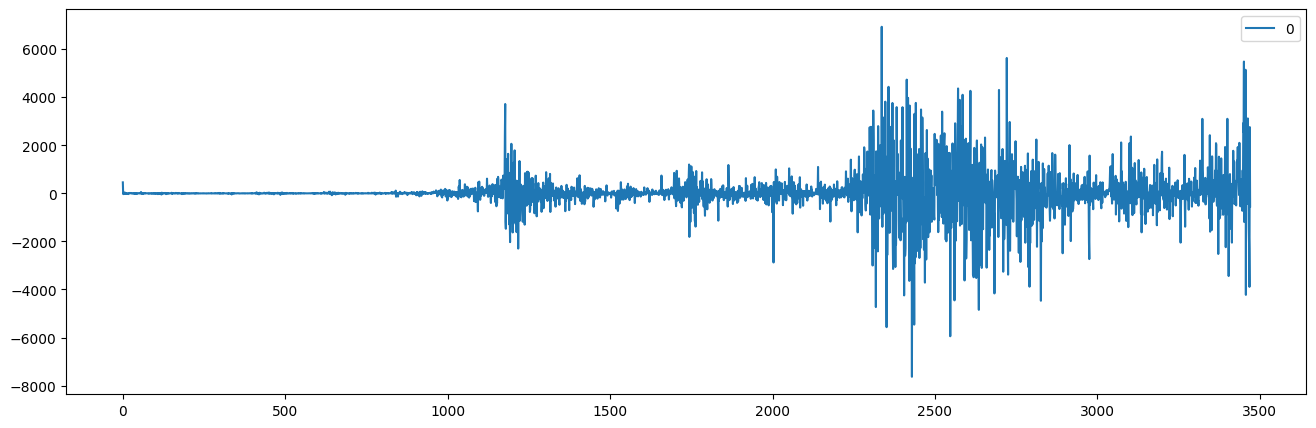

In [11]:
residualAic= pd.DataFrame(model_arima.resid)
residualAic.plot(figsize = (16,5));
plt.show();

Los errores residuales parecen fluctuar alrededor de una media de cero y tienen una varianza uniforme.

GRAFICAMOS EL AJUSTE DE NUESTRO MODELO **ARIMA** 

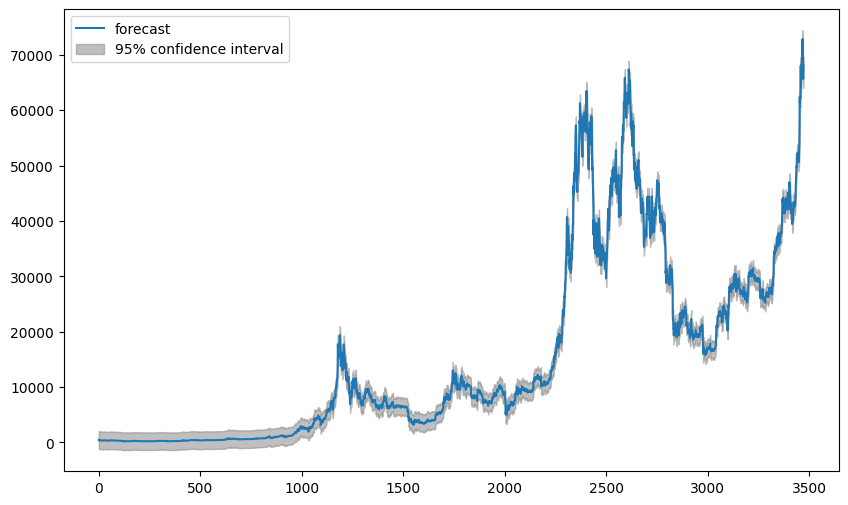

In [12]:
plt.rcParams.update({'figure.figsize': (10,6)})
fig, ax = plt.subplots();
plot_predict(model_arima, 1, ax=ax);
plt.show();

FUNCION PARA LAS PREDICIONES USANDO ROLLING FORECASTING PARA LOS HORIZONTES DE 7, 14, 21 Y 28 DÍAS

In [13]:
def arima_rolling(history, test, horizon=1):
   
    predictions = []
    history = list(history)  
    
    for t in range(len(test)):
        model = ARIMA(history, order=best_order)
        model_fit = model.fit()
        output = model_fit.forecast(steps=horizon)
        yhat = output[-1]  
        predictions.append(yhat)
        
        
        history.append(test[t])  
        
        print(f'predicted={yhat}, expected={test[t]}')
    
    return predictions


There is a lot more that you can do with outputs (such as including interactive outputs)
with your book. For more information about this, see [the Jupyter Book documentation](https://jupyterbook.org)

PREDICIONES PARA LOS HORIZONTES DE 7, 14, 21 Y 28 DÍAS

In [14]:
train_list = train.tolist()   
test_list = test.tolist() 
horizontes = [7, 14, 21, 28]  

predicciones_por_horizonte = {}

for h in horizontes:
    y_predict = arima_rolling(train_list, test_list, horizon=h)
    predicciones_por_horizonte[h] = y_predict
    print(f"Predicciones para horizonte de {h} días: {y_predict}")


predicted=67440.09142332648, expected=61912.7734375
predicted=61519.363058482275, expected=67913.671875
predicted=67450.0178722883, expected=65491.390625
predicted=65902.87979241333, expected=63778.76171875
predicted=64095.847412581476, expected=64062.203125
predicted=63597.78738057375, expected=67234.171875
predicted=66977.71833493585, expected=69958.8125
predicted=70029.1284200867, expected=69987.8359375
predicted=69921.26731722837, expected=69455.34375
predicted=69440.61758156569, expected=70744.953125
predicted=70845.45637579926, expected=69892.828125
predicted=69726.67685308737, expected=69645.3046875
predicted=69681.39070497334, expected=71333.6484375
predicted=71238.31577554984, expected=69702.1484375
predicted=69883.77927621691, expected=65446.97265625
predicted=65404.609049682964, expected=65980.8125
predicted=65962.6533303559, expected=68508.84375
predicted=68192.51992213874, expected=67837.640625
predicted=67880.40072694229, expected=68896.109375
predicted=69073.85788996144,

GRAFICAMOS LAS PREDICIONES OBTENIDAS

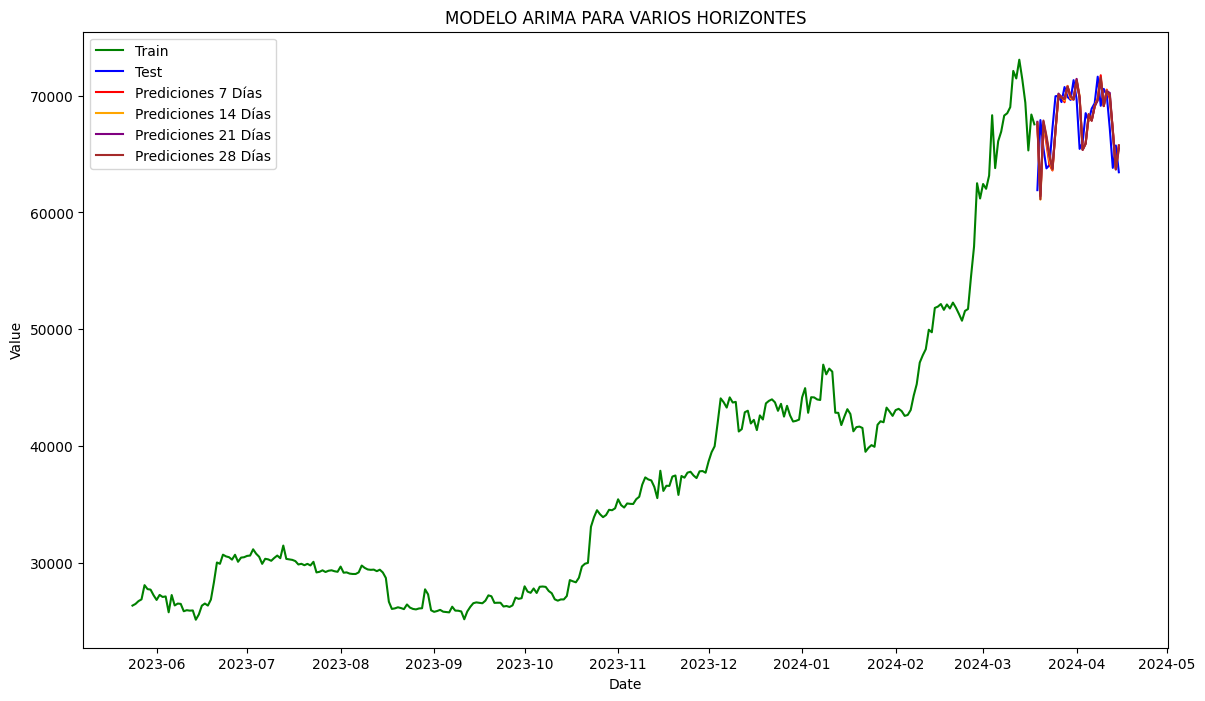

In [15]:
plt.figure(figsize=(14, 8))
ax = plt.gca()

sns.lineplot(x=dates_train[-300:], y=train[-300:], label="Train", color='green', ax=ax)
sns.lineplot(x=dates_test, y=test, label="Test", color='blue', ax=ax)

colors = ['red', 'orange', 'purple', 'brown']  
for i, h in enumerate(horizontes):
   
    prediction_dates = dates_test[:len(predicciones_por_horizonte[h])]  
    sns.lineplot(x=prediction_dates, y=predicciones_por_horizonte[h], label=f"Prediciones {h} Días", color=colors[i], ax=ax)

plt.title('MODELO ARIMA PARA VARIOS HORIZONTES')
plt.xlabel('Date')
plt.ylabel('Value')

plt.legend()
plt.show()



Podemos ver que la predicciones tiene un comportamiento parecido a los datos originales.

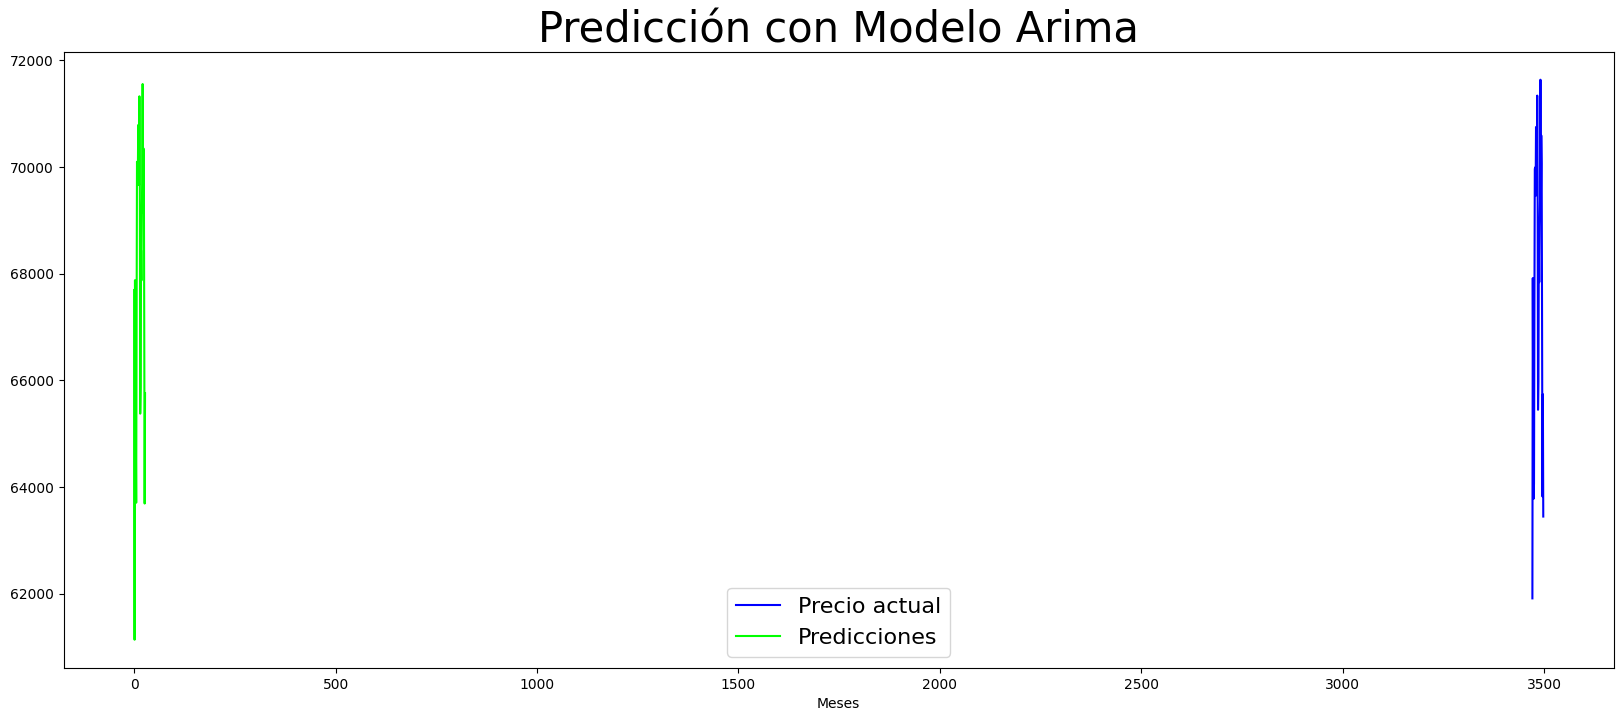

In [16]:
#plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(test,color="blue" ,label="Precio actual")
plt.plot(y_predict, color="lime", label="Predicciones")
plt.title("Predicción con Modelo Arima", fontsize=30);
plt.xlabel('Meses')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

Función para evaluar

In [17]:
def evaluacion_metrica(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

Evaluamos Metricas:

In [18]:
evaluacion_metrica(test,y_predict)


Evaluation metric results:-
MSE is : 6756806.795552885
MAE is : 2039.8982907386312
RMSE is : 2599.3858496869766
MAPE is : 3.057729038577908
R2 is : 0.03943360813183172



Guardemos los datos, para luego hacer unas comparaciones con los demás modelos.

## PUNTO 3
Repita el paso 2 ahora sin utilizar rolling. Esto es, realice el pronóstico solo utilizando forecast() para los diferentes horizontes de predicción, 7, 14, 21 y 28 días.

Aplicamos el bucle **FOR** para realizar predicciones con los diferentes horizontes de tiempo usando el modelo ARIMA ya entrenado

In [19]:
horizontes = [7, 14, 21, 28]
predictions = {}

for dias in horizontes:
    y_forecast = model_arima.forecast(steps=dias)
    predictions[dias] = y_forecast
    print(f"Predicciones para {dias} días: {y_forecast}")
    y_predFore = predictions[dias]
    

Predicciones para 7 días: 3471    67667.256910
3472    67599.041186
3473    67586.561463
3474    67781.741749
3475    67554.709514
3476    67790.046742
3477    67440.091423
Name: predicted_mean, dtype: float64
Predicciones para 14 días: 3471    67667.256910
3472    67599.041186
3473    67586.561463
3474    67781.741749
3475    67554.709514
3476    67790.046742
3477    67440.091423
3478    67770.922386
3479    67518.146572
3480    67810.741407
3481    67574.598869
3482    67676.867053
3483    67578.047855
3484    67624.494301
Name: predicted_mean, dtype: float64
Predicciones para 21 días: 3471    67667.256910
3472    67599.041186
3473    67586.561463
3474    67781.741749
3475    67554.709514
3476    67790.046742
3477    67440.091423
3478    67770.922386
3479    67518.146572
3480    67810.741407
3481    67574.598869
3482    67676.867053
3483    67578.047855
3484    67624.494301
3485    67717.544372
3486    67619.274753
3487    67726.675085
3488    67514.182240
3489    67708.906941
3490  

Código para realizar predicciones manualmente con los diferentes horizontes de tiempo usando el modelo ARIMA ya entrenado

In [20]:
dates_start = len(BTC_df.date[:train_size])

dates_predict7 = dates_start + 7
dates_predict14 = dates_start + 14
dates_predict21 = dates_start + 21
dates_predict28 = dates_start + 28

arima_pred7 = model_arima.predict(start = dates_start, end = dates_predict7, typ="levels").rename("ARIMA Predictions")
arima_pred14 = model_arima.predict(start = dates_start, end = dates_predict14, typ="levels").rename("ARIMA Predictions")
arima_pred21 = model_arima.predict(start = dates_start, end = dates_predict21, typ="levels").rename("ARIMA Predictions")
arima_pred28 = model_arima.predict(start = dates_start, end = dates_predict28, typ="levels").rename("ARIMA Predictions")

arima_pred28


3471    67667.256910
3472    67599.041186
3473    67586.561463
3474    67781.741749
3475    67554.709514
3476    67790.046742
3477    67440.091423
3478    67770.922386
3479    67518.146572
3480    67810.741407
3481    67574.598869
3482    67676.867053
3483    67578.047855
3484    67624.494301
3485    67717.544372
3486    67619.274753
3487    67726.675085
3488    67514.182240
3489    67708.906941
3490    67562.861834
3491    67767.054799
3492    67600.965386
3493    67674.601729
3494    67576.532504
3495    67638.665728
3496    67682.530184
3497    67653.135741
3498    67691.305707
3499    67561.714319
Name: ARIMA Predictions, dtype: float64

Ahora graficamos los datos de entrenamiento, los datos de prueba y las prediciones obtenida por cada horizonte

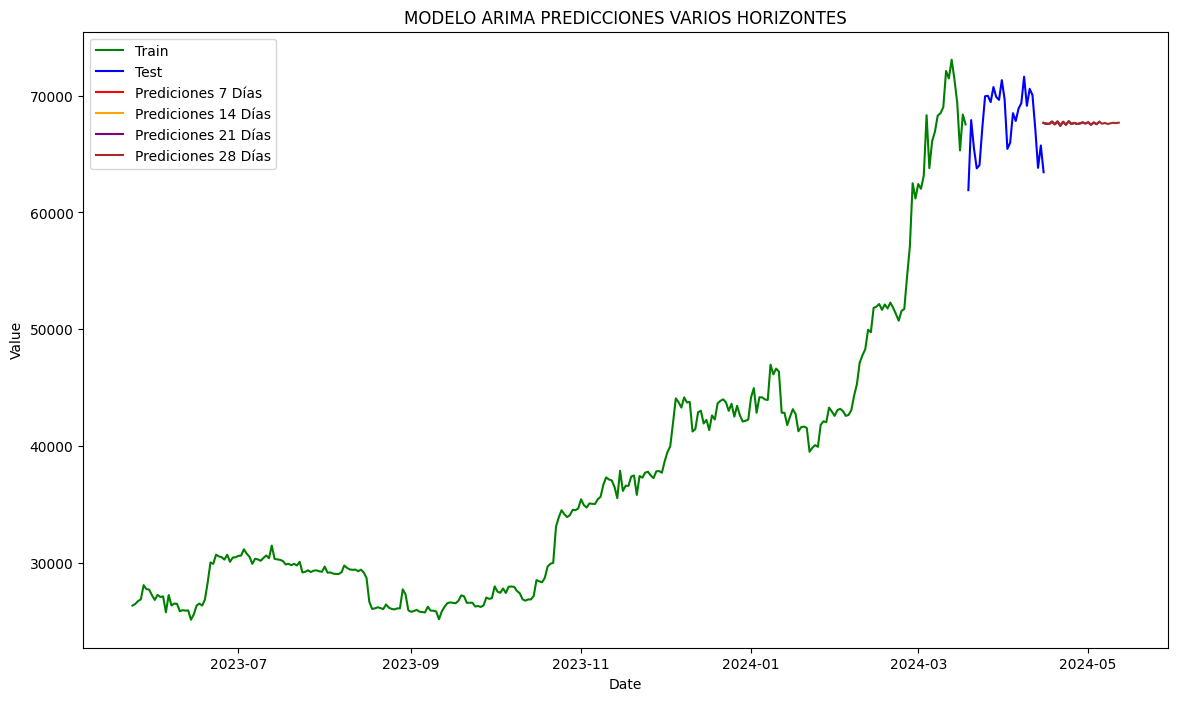

In [21]:
plt.figure(figsize=(14, 8))
ax = plt.gca()

# Graficar los datos de entrenamiento y prueba
sns.lineplot(x=dates_train[-300:], y=train[-300:], label="Train", color='green', ax=ax)
sns.lineplot(x=dates_test, y=test, label="Test", color='blue', ax=ax)

# Graficar las predicciones para cada horizonte
colors = ['red', 'orange', 'purple', 'brown']  # Colores para los diferentes horizontes
for i, h in enumerate(horizontes):
  
    prediction_dates = pd.date_range(start=dates_test.iloc[-1], periods=h, freq='D')
    sns.lineplot(x=prediction_dates, y=predictions[h], label=f"Prediciones {h} Días", color=colors[i], ax=ax)

plt.title('MODELO ARIMA PREDICCIONES VARIOS HORIZONTES')
plt.xlabel('Date')
plt.ylabel('Value')


plt.legend()
plt.show()


La gráfica muestra que las predicciones del modelo ARIMA no siguen la tendencia de los datos de prueba

Realizamos la grafica solo con los datos de prueba y las predicciones obtenidas

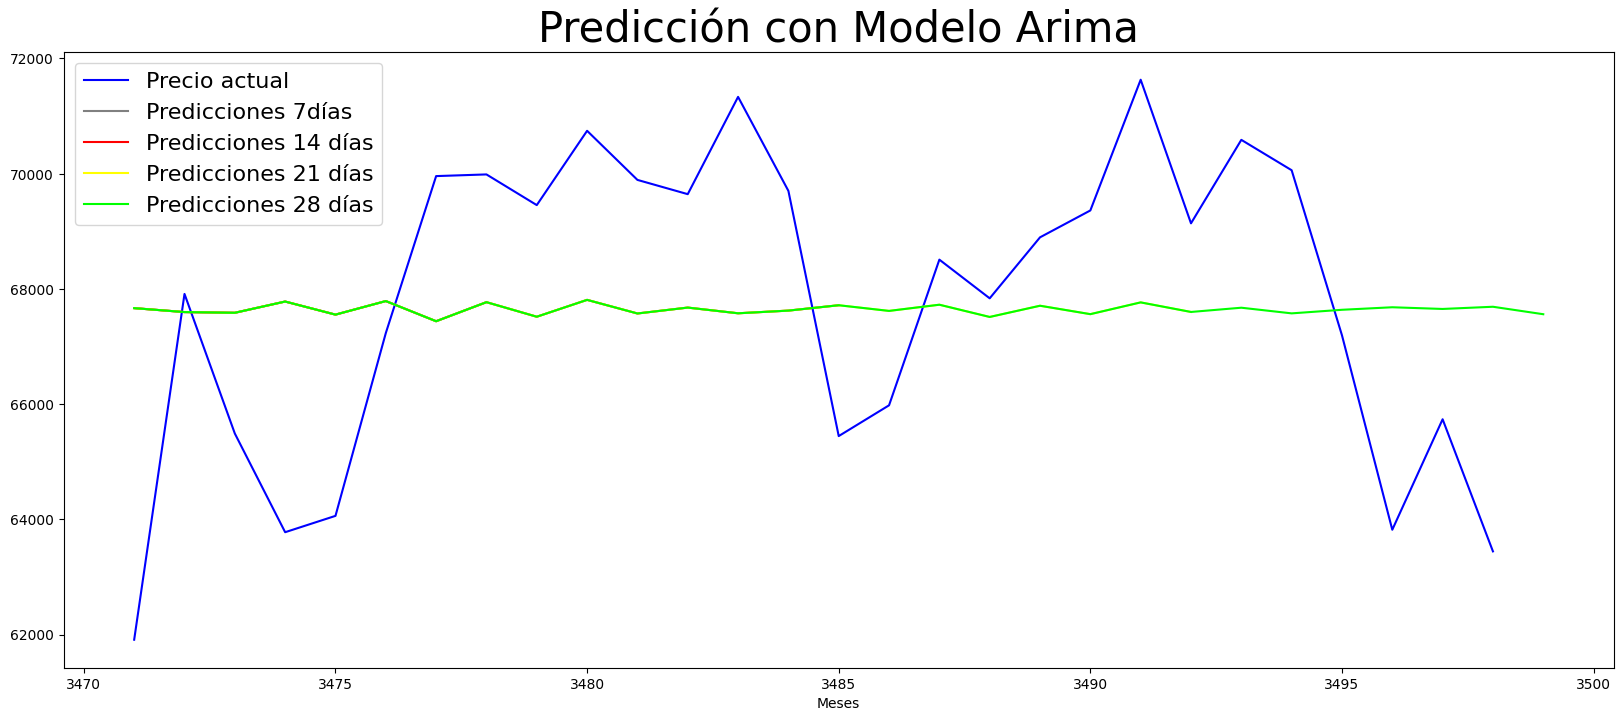

In [22]:

plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(test,color="blue" ,label="Precio actual")
plt.plot(arima_pred7, color="Gray", label="Predicciones 7días")
plt.plot(arima_pred14, color="Red", label="Predicciones 14 días")
plt.plot(arima_pred21, color="Yellow", label="Predicciones 21 días")
plt.plot(arima_pred28, color="lime", label="Predicciones 28 días")
plt.title("Predicción con Modelo Arima", fontsize=30);
plt.xlabel('Meses')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

En conclusión vemos que el metodo de predicción rolling forecasting predicce mucho mejor que solo utilizando **`forecast()`**, Esto debido a que el modelo se recalibra constantemente con la información más reciente. Esto permite que el modelo se adapte mejor a cambios recientes en la tendencia o en la volatilidad, que pueden ser muy frecuentes en series temporales financieras como las del Bitcoin.

## PUNTO 4   
Realice tablas de error para los ítems 1 y 2, utilizando las métricas: MAPE, MAE, RMSE, MSE, R2. Además, agregue el gráfico de correlación entre la observación real y su predicción en el test.

In [23]:
def forecast_accuracy(forecast, actual, str_name):
    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) # MAPE
    mae = np.mean(np.abs(forecast - actual))                 # MAE
    rmse = np.mean((forecast - actual)**2)**.5               # RMSE
    mse = np.mean((forecast - actual)**2)                    # MSE
    r2 = r2_score(forecast, actual)
    
    df_acc = pd.DataFrame({'MAE': [mae],
                           'MSE': [mse],
                           'MAPE': [mape],
                           'RMSE': [rmse],
                           'R2': [r2]},
                          index=[str_name])
    
    return df_acc

In [24]:
forecast_accuracy(np.array(test), np.array(y_predict), "week 1")

,MAE,MSE,MAPE,RMSE,R2
week 1,2039.898291,6.756807e+06,0.030497,2599.38585,0.039434


El R² es bastante bajo, lo que indica que el modelo explica solo un 3.94% de la variabilidad de los datos objetivo
Con el metodo rolling forecasting tenemos errores aceptables, lo cual indica que hay espacio para mejorar el modelo, posiblemente mediante la exploración de diferentes enfoques en la modelización 

Text(0, 0.5, 'Predicciones')

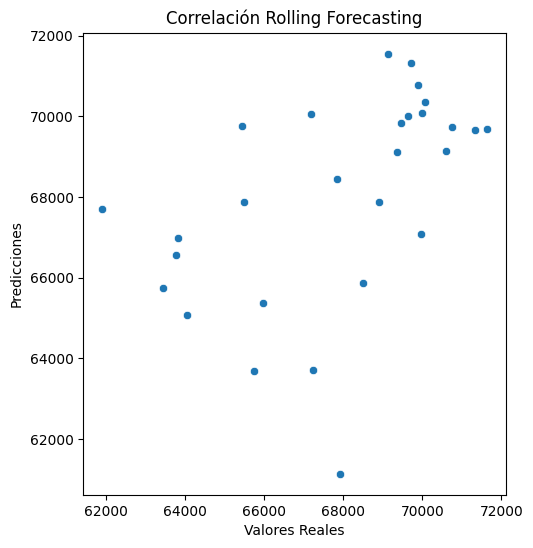

In [25]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=test, y=y_predict)
plt.title('Correlación Rolling Forecasting')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')

El gráfico nos muestra puntos dispersos lejos de la línea indican predicciones inexactas.

In [26]:
forecast_accuracy(np.array(test), np.array(y_predFore), "week 1")

,MAE,MSE,MAPE,RMSE,R2
week 1,2328.840481,7.120628e+06,0.034422,2668.45052,-0.012288


Como tenemos horizontes de predicción pequeños aumenta el error de medición o las inexactitudes lo que lleva a un peor rendimiento del modelo y valores de R² negativos

Text(0, 0.5, 'Predicciones')

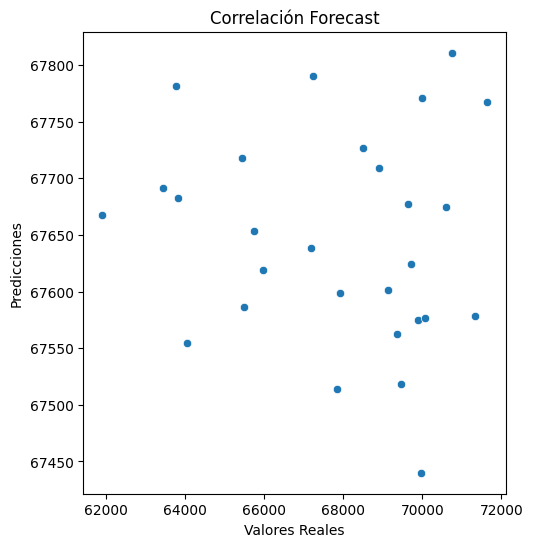

In [27]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=test, y=y_predFore)
plt.title('Correlación Forecast')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')

El gráfico nos muestra puntos dispersos lejos de la línea indican predicciones inexactas.

## PUNTO 5
Repita el análisis desarrollado en los pasos anteriores, considerando ahora el criterio de inferencia Bayesiana (BIC) y el criterio de información de Hannan–Quinn (HQIC) para encontrar el mejor modelo ARIMA y, compare los errores con aquellos obtenidos con el criterio de Akaike.


In [28]:
best_bic = np.inf
best_orderbic = None
best_mdl = None

pq_rng = range(5)  
d_rng = range(3)   

for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                print(f"Testing model ARIMA({i}, {d}, {j})")
                tmp_mdl = ARIMA(train, order=(i, d, j)).fit()
                tmp_bic = tmp_mdl.bic
                print(f"Model BIC: {tmp_bic}")
                if tmp_bic < best_bic:
                    best_bic = tmp_bic
                    best_orderbic = (i, d, j)
                    best_mdl = tmp_mdl
            except Exception as e:
                print(f"Failed to fit ARIMA({i}, {d}, {j}): {str(e)}")
                continue

print(f"Best BIC: {best_bic} with order {best_orderbic}")


Testing model ARIMA(0, 0, 0)
Model BIC: 102301.68967062836
Testing model ARIMA(0, 0, 1)
Model BIC: 72906.91930803745
Testing model ARIMA(0, 0, 2)
Model BIC: 69226.83082105401
Testing model ARIMA(0, 0, 3)
Model BIC: 66552.48456220613
Testing model ARIMA(0, 0, 4)
Model BIC: 71814.30009550662
Testing model ARIMA(0, 1, 0)
Model BIC: 56345.06027194312
Testing model ARIMA(0, 1, 1)
Model BIC: 56349.54054771649
Testing model ARIMA(0, 1, 2)
Model BIC: 56354.82320313497
Testing model ARIMA(0, 1, 3)
Model BIC: 56361.482219692916
Testing model ARIMA(0, 1, 4)
Model BIC: 56365.62829440369
Testing model ARIMA(0, 2, 0)
Model BIC: 58847.913161273755
Testing model ARIMA(0, 2, 1)
Model BIC: 56343.53343502409
Testing model ARIMA(0, 2, 2)
Model BIC: 56347.9632335511
Testing model ARIMA(0, 2, 3)
Model BIC: 56353.303773564294
Testing model ARIMA(0, 2, 4)
Model BIC: 56359.991794273636
Testing model ARIMA(1, 0, 0)
Model BIC: 56384.42755979595
Testing model ARIMA(1, 0, 1)
Model BIC: 56388.928732180604
Testing m

Como podemos ver, el mejor orden de los valore P, D, Q elegidos son Arima(0,2,1) 

Implementamos el modelos con los valores obtenidos:

In [29]:
modelBic = ARIMA(train, order=best_orderbic)
model_arimaBic = modelBic.fit()
print(model_arimaBic.summary())


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 3471
Model:                 ARIMA(0, 2, 1)   Log Likelihood              -28163.615
Date:                Mon, 15 Apr 2024   AIC                          56331.230
Time:                        18:33:56   BIC                          56343.533
Sample:                             0   HQIC                         56335.623
                               - 3471                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9997      0.001   -899.759      0.000      -1.002      -0.998
sigma2      6.588e+05   5422.737    121.486      0.000    6.48e+05    6.69e+05
Ljung-Box (L1) (Q):                   4.10   Jarque-

Gráfica de residuos del modelo ARIMA BIC

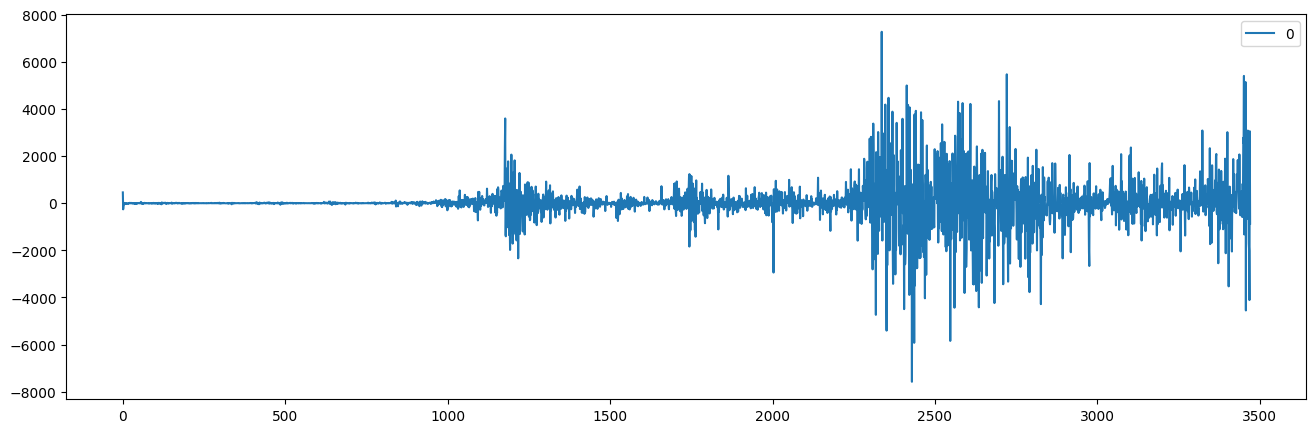

In [30]:
# Gráfico de línea de errores residuales
residualBic = pd.DataFrame(model_arimaBic.resid)
residualBic.plot(figsize = (16,5));
plt.show();

Los errores residuales parecen fluctuar alrededor de una media de cero y tienen una varianza uniforme.

Función ARIMA Rolling

In [31]:
def arimabic_rolling(history, test, horizon=1):
   
    predictions = []
    history = list(history)  
    
    for t in range(len(test)):
        model = ARIMA(history, order=best_orderbic)
        model_fit = model.fit()
        output = model_fit.forecast(steps=horizon)
        yhat = output[-1]  
        predictions.append(yhat)
        
        
        history.append(test[t])  
        
        print(f'predicted={yhat}, expected={test[t]}')
    
    return predictions

Código para las predicciones por cada Horizonte

In [32]:
train_list = train.tolist() 
test_list = test.tolist()  
horizontes = [7, 14, 21, 28] 

predicciones_por_horizontebic = {}

for h in horizontes:
    y_predictbic = arimabic_rolling(train_list, test_list, horizon=h)
    predicciones_por_horizontebic[h] = y_predictbic
    print(f"Predicciones para horizonte de {h} días: {y_predictbic}")

predicted=67707.83091781083, expected=61912.7734375
predicted=62060.80187901603, expected=67913.671875
predicted=68071.49887314321, expected=65491.390625
predicted=65644.61486821431, expected=63778.76171875
predicted=63928.164351559804, expected=64062.203125
predicted=64212.224572789644, expected=67234.171875
predicted=67392.73737132354, expected=69958.8125
predicted=70122.28235554753, expected=69987.8359375
predicted=70151.17012612573, expected=69455.34375
predicted=69617.16671664783, expected=70744.953125
predicted=70910.46835605211, expected=69892.828125
predicted=70055.77196795541, expected=69645.3046875
predicted=69810.25485769415, expected=71333.6484375
predicted=71500.40580771529, expected=69702.1484375
predicted=69866.88956231177, expected=65446.97265625
predicted=65602.17444115417, expected=65980.8125
predicted=66136.9476939274, expected=68508.84375
predicted=68671.93657120068, expected=67837.640625
predicted=67999.30520469743, expected=68896.109375
predicted=69060.32300987653

Ahora graficamos los datos de entrenamiento, los datos de prueba y las prediciones obtenida por cada horizonte

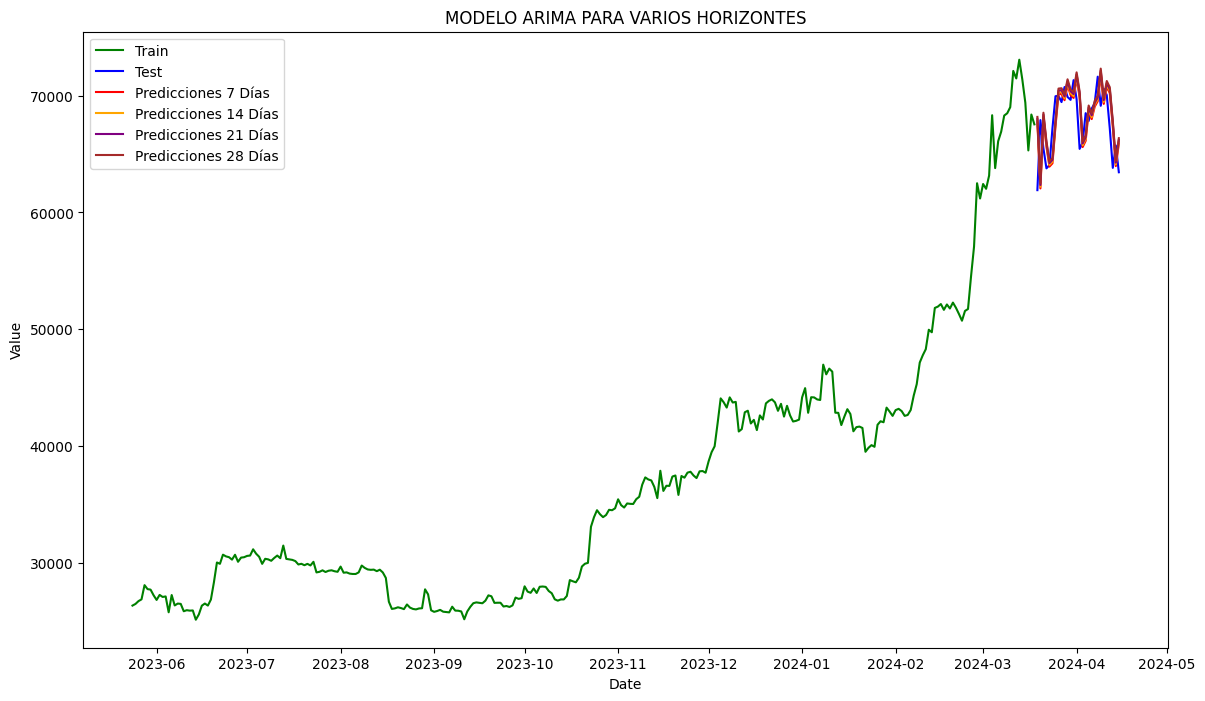

In [33]:
plt.figure(figsize=(14, 8))
ax = plt.gca()

sns.lineplot(x=dates_train[-300:], y=train[-300:], label="Train", color='green', ax=ax)
sns.lineplot(x=dates_test, y=test, label="Test", color='blue', ax=ax)

colors = ['red', 'orange', 'purple', 'brown']  
for i, h in enumerate(horizontes):
   
    prediction_dates = dates_test[:len(predicciones_por_horizontebic[h])]  
    sns.lineplot(x=prediction_dates, y=predicciones_por_horizontebic[h], label=f"Predicciones {h} Días", color=colors[i], ax=ax)

plt.title('MODELO ARIMA PARA VARIOS HORIZONTES')
plt.xlabel('Date')
plt.ylabel('Value')

plt.legend()
plt.show()


Podemos ver que la predicciones tiene un comportamiento parecido a los datos originales.

In [34]:
forecast_accuracy(np.array(test), np.array(y_predictbic), "week 1")

,MAE,MSE,MAPE,RMSE,R2
week 1,2057.744925,6.764252e+06,0.030186,2600.817539,0.038375


El R² es bastante bajo, lo que indica que el modelo explica solo un 3.83% de la variabilidad de los datos objetivo. 

Con el metodo rolling forecasting tenemos errores aceptables, lo cual indica que hay espacio para mejorar el modelo, posiblemente mediante la exploración de diferentes enfoques en la modelización 

Text(0, 0.5, 'Predicciones')

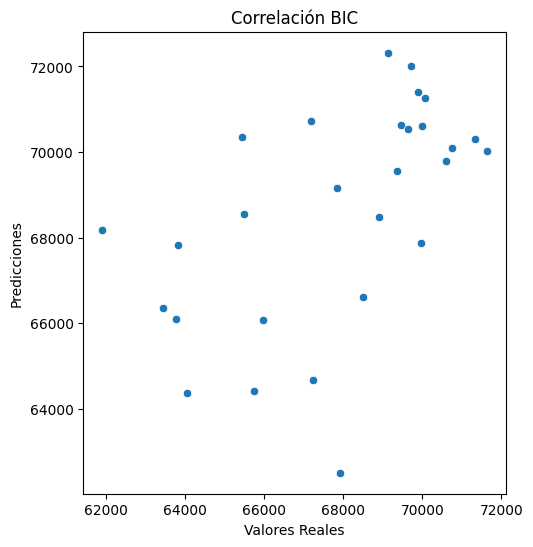

In [35]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=test, y=y_predictbic)
plt.title('Correlación BIC')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')

El gráfico nos muestra puntos dispersos lejos de la línea indican predicciones inexactas.

Código para calcular el mejor HQIC y el mejor orden de los valores P, D, Q

In [36]:
best_hqic = np.inf
best_orderhqic = None
best_mdl = None

pq_rng = range(5)  
d_rng = range(3)   

for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                print(f"Testing model ARIMA({i}, {d}, {j})")
                tmp_mdl = ARIMA(train, order=(i, d, j)).fit()
                tmp_hqic = tmp_mdl.hqic
                print(f"Model HQIC: {tmp_hqic}")
                if tmp_hqic < best_hqic:
                    best_hqic = tmp_hqic
                    best_orderhqic = (i, d, j)
                    best_mdl = tmp_mdl
            except Exception as e:
                print(f"Failed to fit ARIMA({i}, {d}, {j}): {str(e)}")
                continue

print(f"Best HQIC: {best_hqic} with order {best_orderhqic}")


Testing model ARIMA(0, 0, 0)
Model HQIC: 102293.77842494099
Testing model ARIMA(0, 0, 1)
Model HQIC: 72895.0524395064
Testing model ARIMA(0, 0, 2)
Model HQIC: 69211.00832967929
Testing model ARIMA(0, 0, 3)
Model HQIC: 66532.70644798772
Testing model ARIMA(0, 0, 4)
Model HQIC: 71790.56635844451
Testing model ARIMA(0, 1, 0)
Model HQIC: 56341.10486655025
Testing model ARIMA(0, 1, 1)
Model HQIC: 56341.62973693076
Testing model ARIMA(0, 1, 2)
Model HQIC: 56342.95698695637
Testing model ARIMA(0, 1, 3)
Model HQIC: 56345.66059812145
Testing model ARIMA(0, 1, 4)
Model HQIC: 56345.85126743936
Testing model ARIMA(0, 2, 0)
Model HQIC: 58843.95797339188
Testing model ARIMA(0, 2, 1)
Model HQIC: 56335.623059260346
Testing model ARIMA(0, 2, 2)
Model HQIC: 56336.09766990547
Testing model ARIMA(0, 2, 3)
Model HQIC: 56337.4830220368
Testing model ARIMA(0, 2, 4)
Model HQIC: 56340.21585486427
Testing model ARIMA(1, 0, 0)
Model HQIC: 56372.560691264895
Testing model ARIMA(1, 0, 1)
Model HQIC: 56373.10624080

Como podemos ver, el mejor orden de los valore P, D, Q elegidos son Arima(4,1,4) 

Implementamos el modelo con los datos obtenidos:

In [37]:
modelHqic = ARIMA(train, order=best_orderhqic)
model_arimaHqic = modelHqic.fit()
print(model_arimaHqic.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 3471
Model:                 ARIMA(4, 1, 4)   Log Likelihood              -28142.899
Date:                Mon, 15 Apr 2024   AIC                          56303.798
Time:                        18:36:11   BIC                          56359.165
Sample:                             0   HQIC                         56323.566
                               - 3471                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0014      0.023    -43.454      0.000      -1.047      -0.956
ar.L2         -0.3394      0.010    -34.884      0.000      -0.359      -0.320
ar.L3         -1.0378      0.010   -106.985      0.0

Gráfica de residuos del modelo ARIMA HQIC

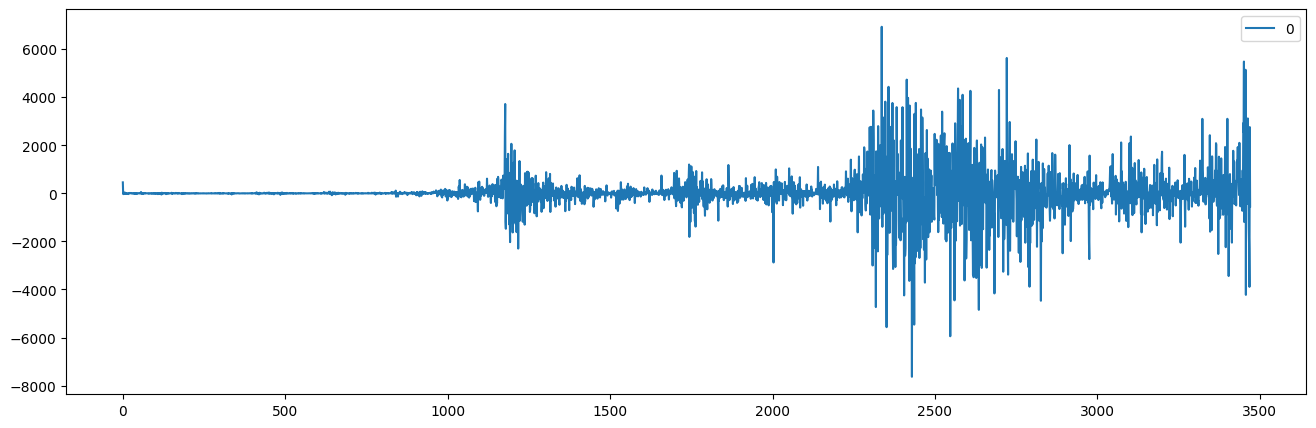

In [38]:
residualHqic = pd.DataFrame(model_arimaHqic.resid)
residualHqic.plot(figsize = (16,5));
plt.show();

Los errores residuales parecen fluctuar alrededor de una media de cero y tienen una varianza uniforme.

Función ARIMA Rolling

In [39]:
def arimahqic_rolling(history, test, horizon=1):
   
    predictions = []
    history = list(history)  
    
    for t in range(len(test)):
        model = ARIMA(history, order=best_orderhqic)
        model_fit = model.fit()
        output = model_fit.forecast(steps=horizon)
        yhat = output[-1]  
        predictions.append(yhat)
        
        
        history.append(test[t])  
        
        print(f'predicted={yhat}, expected={test[t]}')
    
    return predictions

Código para las predicciones por cada Horizonte

In [40]:
train_list = train.tolist()  
test_list = test.tolist()  
horizontes = [7, 14, 21, 28]  

predicciones_por_horizontehqic = {}

for h in horizontes:
    y_predicthqic = arimahqic_rolling(train_list, test_list, horizon=h)
    predicciones_por_horizontehqic[h] = y_predicthqic
    print(f"Predicciones para horizonte de {h} días: {y_predicthqic}")

predicted=67440.09142332648, expected=61912.7734375
predicted=61519.363058482275, expected=67913.671875
predicted=67450.0178722883, expected=65491.390625
predicted=65902.87979241333, expected=63778.76171875
predicted=64095.847412581476, expected=64062.203125
predicted=63597.78738057375, expected=67234.171875
predicted=66977.71833493585, expected=69958.8125
predicted=70029.1284200867, expected=69987.8359375
predicted=69921.26731722837, expected=69455.34375
predicted=69440.61758156569, expected=70744.953125
predicted=70845.45637579926, expected=69892.828125
predicted=69726.67685308737, expected=69645.3046875
predicted=69681.39070497334, expected=71333.6484375
predicted=71238.31577554984, expected=69702.1484375
predicted=69883.77927621691, expected=65446.97265625
predicted=65404.609049682964, expected=65980.8125
predicted=65962.6533303559, expected=68508.84375
predicted=68192.51992213874, expected=67837.640625
predicted=67880.40072694229, expected=68896.109375
predicted=69073.85788996144,

Ahora graficamos los datos de entrenamiento, los datos de prueba y las prediciones obtenida por cada horizonte

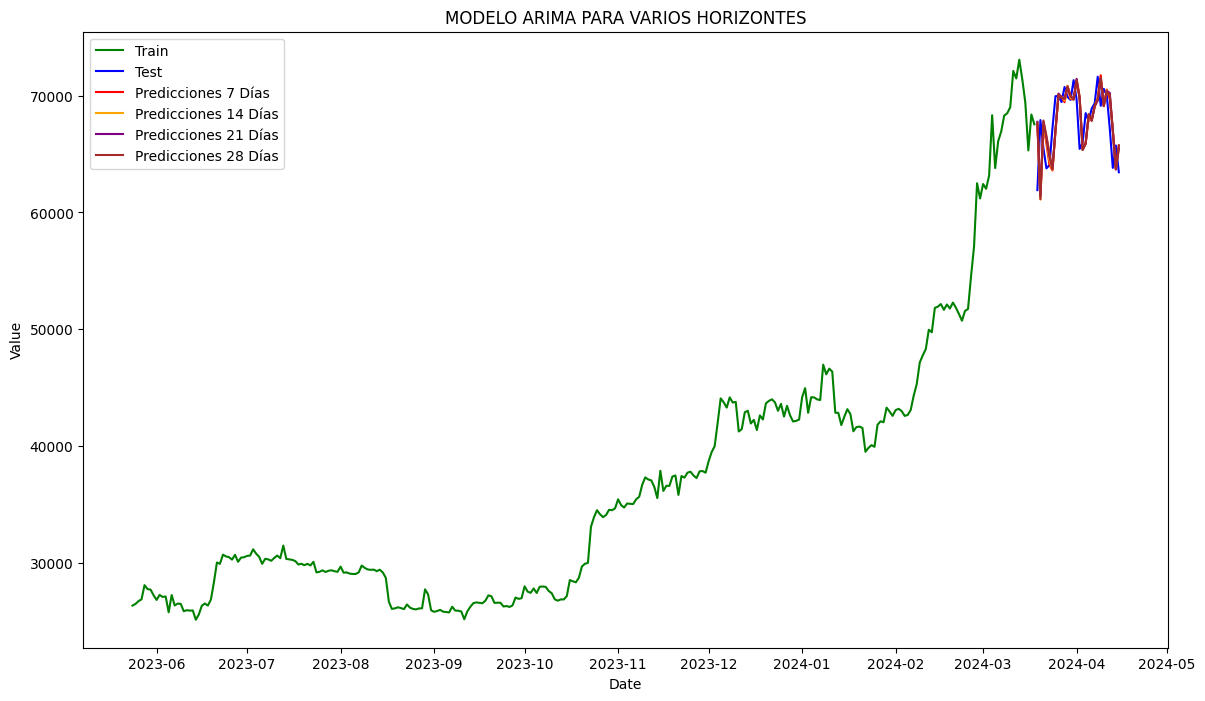

In [41]:
plt.figure(figsize=(14, 8))
ax = plt.gca()

sns.lineplot(x=dates_train[-300:], y=train[-300:], label="Train", color='green', ax=ax)
sns.lineplot(x=dates_test, y=test, label="Test", color='blue', ax=ax)

colors = ['red', 'orange', 'purple', 'brown']  
for i, h in enumerate(horizontes):
   
    prediction_dates = dates_test[:len(predicciones_por_horizontehqic[h])]  
    sns.lineplot(x=prediction_dates, y=predicciones_por_horizontehqic[h], label=f"Predicciones {h} Días", color=colors[i], ax=ax)

plt.title('MODELO ARIMA PARA VARIOS HORIZONTES')
plt.xlabel('Date')
plt.ylabel('Value')

plt.legend()
plt.show()

Podemos ver que la predicciones tiene un comportamiento parecido a los datos originales.

In [42]:
forecast_accuracy(np.array(test), np.array(y_predicthqic), "week 1")

,MAE,MSE,MAPE,RMSE,R2
week 1,2039.898291,6.756807e+06,0.030497,2599.38585,0.039434


El R² es bastante bajo, lo que indica que el modelo explica solo un 3.94% de la variabilidad de los datos objetivo. 

Con el metodo rolling forecasting tenemos errores aceptables, lo cual indica que hay espacio para mejorar el modelo, posiblemente mediante la exploración de diferentes enfoques en la modelización 

Text(0, 0.5, 'Predicciones')

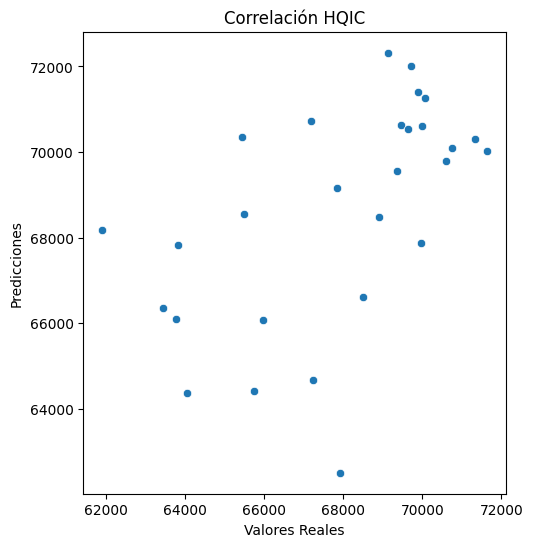

In [43]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=test, y=y_predictbic)
plt.title('Correlación HQIC')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')

El gráfico nos muestra puntos dispersos lejos de la línea indican predicciones inexactas.

## TEST NORMALIDAD
El supuesto de normalidad implica que los residuos deben distribuirse de forma normal.

Aplicamos el Test de **Shapiro-Wilk**

In [44]:
stat, p = shapiro(residualAic)
print('Estadístico de Shapiro-Wilk:', stat)
print('P-valor:', p)
if p > 0.05:
    print('La distribución de los residuos parece normal (no se rechaza H0).')
else:
    print('La distribución de los residuos no parece normal (se rechaza H0).')


Estadístico de Shapiro-Wilk: 0.7118056363173315
P-valor: 6.419744473043037e-61
La distribución de los residuos no parece normal (se rechaza H0).


El resultado estadístico de Shapiro-Wilk: **0.7118** indica una desviación significativa de la normalidad.

## TEST DE INDEPENDENCIA
Los residuos deben ser independientes uno del otro

Aplicamos el Test de **Durbin-Watson**

In [45]:
dw_stat = durbin_watson(residualAic)
print('Estadístico de Durbin-Watson:', dw_stat)
if dw_stat < 1.5 or dw_stat > 2.5:
    print('Posible autocorrelación (los residuos no son independientes).')
else:
    print('No hay evidencia de autocorrelación importante (los residuos parecen independientes).')


Estadístico de Durbin-Watson: [1.97156505]
No hay evidencia de autocorrelación importante (los residuos parecen independientes).


El resultado estadístico de Durbin-Watson: **1.971**  indica la presencia de autocorrelación en los residuos del modelo. Esto significa que un residuo tiene una alta probabilidad de ser seguido por otro residuo.

## CONCLUSIONES

Se logro configurar los modelos predictivo ARIMA que incluso no cumpliendo con los supuestos de estacionariedad de la serie temporal lograron ajustarse a las predicciones.

Vimos que la metodología Rolling forecasting predice mejor los precios de Bitcoin, debido a que tiene la  capacidad para adaptarse a su naturaleza volátil y cambiante.

Se recomienda explorar nuevas técnicas de modelamiento de series temporales para encontrar un mejor rendimiento en cuanto a la predicción.
